In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud

**Dataset:** https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Project 1"

In [4]:
os.chdir("/content/drive/MyDrive/Project 1")

In [5]:
os.listdir()

['Reviews.csv', 'database.sqlite', 'hashes.txt', 'model_plot.png']

Now we load in the dataset and add some columns for upvote metrics:

In [6]:
df = pd.read_csv('Reviews.csv')

In [7]:
df.shape

(568454, 10)

HelpfulnessNumerator: Number of users who found the review helpful

HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not

Helpful%: %age of people who find the review helpful

 % Upvote: Category division for Helpful% 

Because we have limited computational resources we decided to work on 1/10th of the entire dataset.

In [8]:
#Taking 56,845 out of 568,450 reviews
reviewsData= df.sample(frac = 0.1)
reviewsData['Helpful %'] = np.where(reviewsData['HelpfulnessDenominator'] > 0, reviewsData['HelpfulnessNumerator'] / reviewsData['HelpfulnessDenominator'], -1)
reviewsData['% Upvote'] = pd.cut(reviewsData['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
reviewsData.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
124918,124919,B005BHIESC,A1ZSE31RSEU9BR,Lora Applegarth,0,1,1,1325894400,Never again!,"I purchased this thinking ""what a great deal!""...",0.0,Empty
147399,147400,B002R89LHQ,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",1,1,4,1285459200,"Good Tasting, Diabetic Friendly - Recommended","These thinkThin ""100 Chocolate Toffee Nut Bite...",1.0,80-100%
5435,5436,B008YGWIZM,AC1G9PEVXK8JJ,Yitbos78,1,1,5,1346025600,A change of pace!,I purchased some of this special habanero sauc...,1.0,80-100%
497248,497249,B004E4EBMG,A3K98GERRFRE07,Mom of Three,0,0,3,1343260800,"Tasty, Uses Natural Flavoring, But Don't Care ...",My daughter loves this stuff. I thought it ta...,-1.0,Empty
219223,219224,B007Y6P7ZG,A22NAHUYYAYC94,Musicluvr,0,0,4,1346976000,Pleasing taste,I have tried virtually every variety of the Bo...,-1.0,Empty



**Data Exploration**

In [9]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [10]:
df.shape

(568454, 10)

In [11]:
reviewsData.shape

(56845, 12)

In [12]:
reviewsData.dtypes

Id                           int64
ProductId                   object
UserId                      object
ProfileName                 object
HelpfulnessNumerator         int64
HelpfulnessDenominator       int64
Score                        int64
Time                         int64
Summary                     object
Text                        object
Helpful %                  float64
% Upvote                  category
dtype: object

In [13]:
reviewsData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56845 entries, 124918 to 80261
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Id                      56845 non-null  int64   
 1   ProductId               56845 non-null  object  
 2   UserId                  56845 non-null  object  
 3   ProfileName             56842 non-null  object  
 4   HelpfulnessNumerator    56845 non-null  int64   
 5   HelpfulnessDenominator  56845 non-null  int64   
 6   Score                   56845 non-null  int64   
 7   Time                    56845 non-null  int64   
 8   Summary                 56841 non-null  object  
 9   Text                    56845 non-null  object  
 10  Helpful %               56845 non-null  float64 
 11  % Upvote                56845 non-null  category
dtypes: category(1), float64(1), int64(5), object(5)
memory usage: 5.3+ MB


In [14]:
reviewsData.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Helpful %
count,56845.000000,56845.000000,56845.000000,56845.000000,5.684500e+04,56845.000000
mean,284490.951324,1.778028,2.265775,4.184027,1.296113e+09,-0.061455
std,163908.195278,8.319819,8.912112,1.309140,4.806461e+07,0.922100
min,2.000000,0.000000,0.000000,1.000000,9.482400e+08,-1.000000
25%,142328.000000,0.000000,0.000000,4.000000,1.271290e+09,-1.000000
50%,284884.000000,0.000000,1.000000,5.000000,1.310688e+09,0.000000
75%,426152.000000,2.000000,2.000000,5.000000,1.332634e+09,1.000000
max,568441.000000,559.000000,562.000000,5.000000,1.351210e+09,1.000000


In [15]:
##Removing the Duplicates if any
reviewsData.duplicated().sum()
reviewsData.drop_duplicates(inplace=True)

In [16]:
#Check for the null values in each column
reviewsData.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   4
Text                      0
Helpful %                 0
% Upvote                  0
dtype: int64

In [17]:
##Remove the NaN values from the dataset
reviewsData.isnull().sum()
reviewsData.dropna(how='any',inplace=True)

In [18]:
#Check for the null values in each column
reviewsData.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
Helpful %                 0
% Upvote                  0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Score')

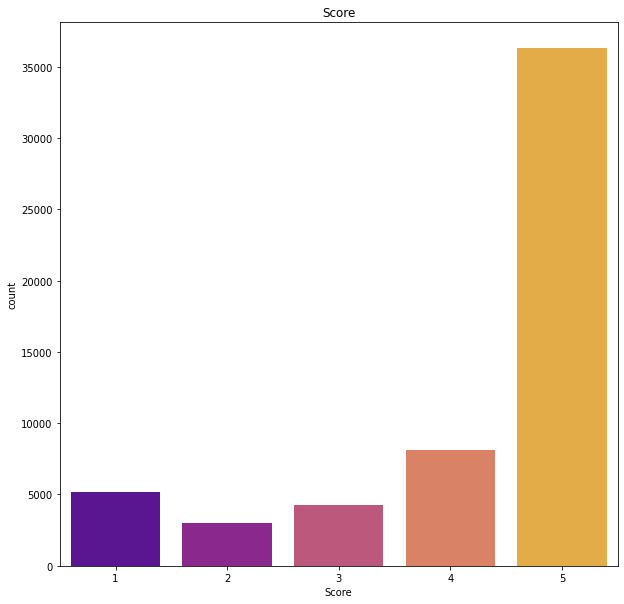

In [19]:
import seaborn as sns
sns.countplot(reviewsData['Score'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Score')

In [20]:
rating_df = pd.DataFrame(reviewsData, columns=['Score', 'Text'])
print(rating_df.shape)
rating_df.head()

(56838, 2)


,Score,Text
124918,1,"I purchased this thinking ""what a great deal!""..."
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite..."
5435,5,I purchased some of this special habanero sauc...
497248,3,My daughter loves this stuff. I thought it ta...
219223,4,I have tried virtually every variety of the Bo...


In [21]:
rating_df['Score'].value_counts()

5    36305
4     8093
1     5193
3     4234
2     3013
Name: Score, dtype: int64

In [22]:
dummies = pd.get_dummies(rating_df['Score'])
dummies.head()

,1,2,3,4,5
124918,1,0,0,0,0
147399,0,0,0,1,0
5435,0,0,0,0,1
497248,0,0,1,0,0
219223,0,0,0,1,0


Text(0.5, 1.0, 'How helpful users find among user scores')

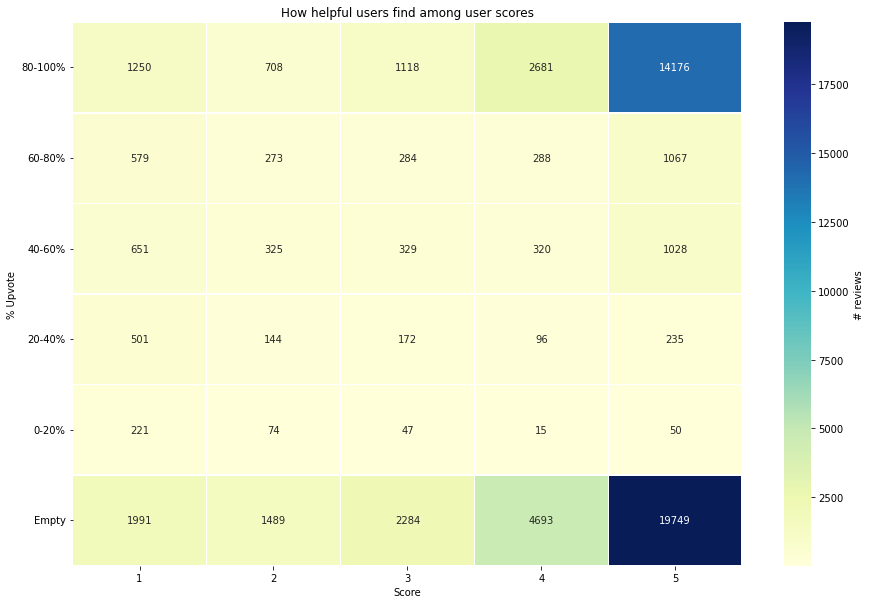

In [23]:
df_s = reviewsData.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:
1.   Reviews are skewed towards positive
2.   More than half of the reviews are with zero votes
3.   Many people agree with score 5 reviews


Then we get rid of score 3 reviews (neutral), and separate the remaining reviews into binary class (1 = positive, 0 = negative):

**Text** **Preprocessing/Cleaning**

In [24]:
import re

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

#stop_words.extend(['crypto','even','early'])

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [25]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.0 MB/s 


In [26]:
import demoji
def handle_emoji(string):
    #x = string.to_string(header=False, index=False)
    emojis = demoji.findall(string)
    #print(emojis)
    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string

In [27]:
def text_cleaner(review):
  # removing the not required texts
  cleaned_review = re.sub(re.compile('<.*?>'), '', review) #removing HTML tags
  cleaned_review = re.sub('[^A-Za-z]+', ' ', cleaned_review) #taking only words
  cleaned_review = handle_emoji(cleaned_review)
  cleaned_review = re.sub(r"http\S+", "", cleaned_review) 
  cleaned_review = cleaned_review.lower()

  tokens = nltk.word_tokenize(cleaned_review)

  filtered_review = [word for word in tokens if word not in stop_words] # removing stop words

  lemm_review = [lemmatizer.lemmatize(word) for word in filtered_review]
  review = " ".join(lemm_review)
  return(review)

In [28]:
cleanText=[]

for t in rating_df['Text']:
 cleanText.append(text_cleaner(t))

rating_df["cleanText"] = cleanText
rating_df.head()

,Score,Text,cleanText
124918,1,"I purchased this thinking ""what a great deal!""...",purchased thinking great deal know really bad ...
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite...",thinkthin chocolate toffee nut bite good tasti...
5435,5,I purchased some of this special habanero sauc...,purchased special habanero sauce past year sup...
497248,3,My daughter loves this stuff. I thought it ta...,daughter love stuff thought tasted pretty good...
219223,4,I have tried virtually every variety of the Bo...,tried virtually every variety body armor brand...


***WORD CLOUD***

In [29]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

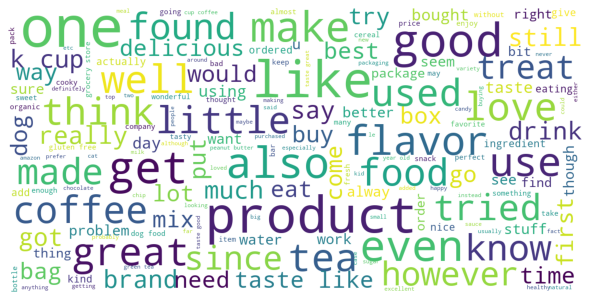

In [30]:
wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42,
        stopwords= stop_words
    ).generate(str(cleanText))                
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [31]:
#After Word Cloud
new_stopwords = ['also','get','one','use','since','got','even','u','say','k']

In [32]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

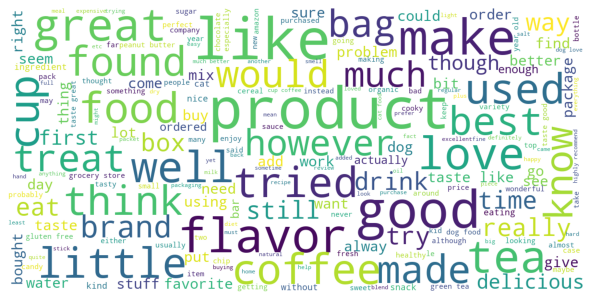

In [33]:
wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42,
        stopwords= stpwrd
    ).generate(str(cleanText))                
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

***TFIDF***

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
rating = rating_df.sample(frac = 0.1)

In [36]:
# def TFIDF_Vect(corpus):
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(rating['cleanText'])
feature_names = vectorizer.get_feature_names_out() 
print(f"Feature names \n {feature_names}")
matrix = vectors.todense()
list_dense = matrix.tolist()
df1=pd.DataFrame(list_dense, columns=feature_names)
print(df1)

Feature names 
 ['aa' 'aaa' 'aaaaaa' ... 'zukes' 'zum' 'zurich']
       aa  aaa  aaaaaa  aaaannnnddd  aafco  aasanfood  aback  abandon  abc  \
0     0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
1     0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
2     0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
3     0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
4     0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
...   ...  ...     ...          ...    ...        ...    ...      ...  ...   
5679  0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
5680  0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
5681  0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
5682  0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   
5683  0.0  0.0     0.0          0.0    0.0        0.0    0.0      0.0  0.0   

As it is visible that words above are being used alot in the documents and hence it is resulting in sparse matrix as we are able  to see a different result only for the word '**able**' for row number 5679.

**VADER Model**

In [37]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Checking VADER model

In [38]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [39]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [40]:
analyzer = SentimentIntensityAnalyzer()
rating_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in rating_df['cleanText']]
rating_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in rating_df['cleanText']]
rating_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in rating_df['cleanText']]
rating_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in rating_df['cleanText']]

In [41]:
rating_df.head()

,Score,Text,cleanText,compound,neg,neu,pos
124918,1,"I purchased this thinking ""what a great deal!""...",purchased thinking great deal know really bad ...,-0.7275,0.342,0.388,0.270
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite...",thinkthin chocolate toffee nut bite good tasti...,0.9118,0.046,0.708,0.245
5435,5,I purchased some of this special habanero sauc...,purchased special habanero sauce past year sup...,0.9938,0.041,0.460,0.499
497248,3,My daughter loves this stuff. I thought it ta...,daughter love stuff thought tasted pretty good...,0.9927,0.000,0.613,0.387
219223,4,I have tried virtually every variety of the Bo...,tried virtually every variety body armor brand...,0.9865,0.030,0.650,0.320


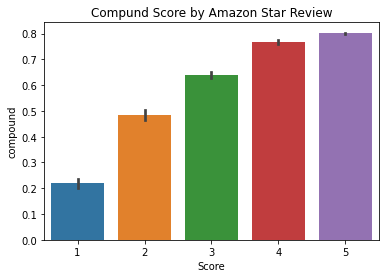

In [42]:
ax = sns.barplot(data=rating_df, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

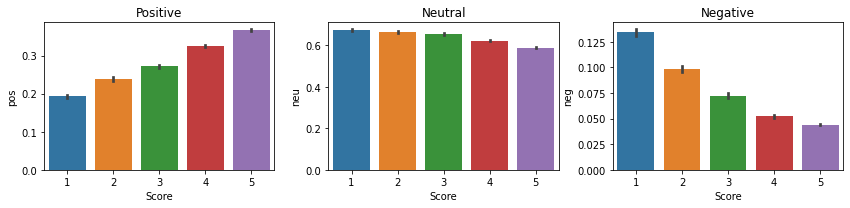

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=rating_df, x='Score', y='pos', ax=axs[0])
sns.barplot(data=rating_df, x='Score', y='neu', ax=axs[1])
sns.barplot(data=rating_df, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

***Business Insights***

The highest positive sentiments are coming from score 5 and there are positive sentiments for score as less as 1 and 2 because these reviews might contain a few positive words or may be sarcastic reviews because many people consider themselves as ***Chandler Bing***.

And vice-versa for negative sentiments. Our insights here is that people might be saying a few negative words for example, "the product is good but the service is bad". So, here a small amount of negative sentiment is picked up because while the customer is satisfied with the product and gave score= 5 but, they are not satisfied with the services. 

Transformer Pipeline

In [44]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 33.1 MB/s 
     |████████████████████████████████| 120 kB 47.8 MB/s 


In [45]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [46]:
sent_pipeline('I like sentimental analysis!')

[{'label': 'POSITIVE', 'score': 0.9989376664161682}]

In [47]:
sent_pipeline(cleanText[:200])

[{'label': 'NEGATIVE', 'score': 0.998892605304718},
 {'label': 'NEGATIVE', 'score': 0.9425846934318542},
 {'label': 'POSITIVE', 'score': 0.9879618287086487},
 {'label': 'POSITIVE', 'score': 0.9717860817909241},
 {'label': 'POSITIVE', 'score': 0.5365245342254639},
 {'label': 'NEGATIVE', 'score': 0.9988357424736023},
 {'label': 'NEGATIVE', 'score': 0.8742316961288452},
 {'label': 'NEGATIVE', 'score': 0.9869824647903442},
 {'label': 'POSITIVE', 'score': 0.9998354911804199},
 {'label': 'NEGATIVE', 'score': 0.9993320107460022},
 {'label': 'NEGATIVE', 'score': 0.9913894534111023},
 {'label': 'POSITIVE', 'score': 0.9973645806312561},
 {'label': 'POSITIVE', 'score': 0.9971874356269836},
 {'label': 'POSITIVE', 'score': 0.9967701435089111},
 {'label': 'POSITIVE', 'score': 0.9991366267204285},
 {'label': 'NEGATIVE', 'score': 0.8985950946807861},
 {'label': 'NEGATIVE', 'score': 0.9853346347808838},
 {'label': 'NEGATIVE', 'score': 0.9963585734367371},
 {'label': 'NEGATIVE', 'score': 0.9995110034942

***Using PATTERN Model***

In [48]:
pip install pattern

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.2 MB 41.8 MB/s 
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 81 kB 9.1 MB/s 
     |████████████████████████████████| 5.6 MB 35.5 MB/s 
     |████████████████████████████████| 5.6 MB 22.4 MB/s 
     |████████████████████████████████| 348 kB 28.7 MB/s 
     |████████████████████████████████| 104 kB 28.0 MB/s 
     |████████████████████████████████| 4.0 MB 37.5 MB/s 
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332721 sha256=50f5a4a3af4042e75d0397ed70321ad7be3209402ad7f592b0babace737ac6ce
  Stored in directory: /root/.cache/pip/wheels/8d/1f/4e/9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for mysqlclient: filename=mysqlclient-2.1.1-cp37-cp37m-linux_x86_64.whl size=99972 sha256=520468421b677e71899b5da87ea6a6aca4d7582c3bfdfa87f6fb510b2ab478f3
  Stored 

In [49]:
from pattern.en import sentiment

(-0.15000000000000002, 0.8)


In [52]:
rating_Pattern = pd.DataFrame(rating_df, columns=['Score', 'Text','cleanText'])

In [53]:
rating_Pattern

,Score,Text,cleanText
124918,1,"I purchased this thinking ""what a great deal!""...",purchased thinking great deal know really bad ...
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite...",thinkthin chocolate toffee nut bite good tasti...
5435,5,I purchased some of this special habanero sauc...,purchased special habanero sauce past year sup...
497248,3,My daughter loves this stuff. I thought it ta...,daughter love stuff thought tasted pretty good...
219223,4,I have tried virtually every variety of the Bo...,tried virtually every variety body armor brand...
...,...,...,...
286291,3,I am an expat living in Thailand so I know a t...,expat living thailand know thing two thai spic...
390514,3,This product is widely available in my area at...,product widely available area local grocery st...
295707,2,My main beef with this product is with the lab...,main beef product labeling box labeled decepti...
465988,4,I have been drinking this tea every night just...,drinking tea every night benefit claim produce...


In [63]:
def patternsnp(text):
  return sentiment(text)

In [71]:
pol=[]
sub=[]
for t in rating_Pattern['cleanText']:
 pol.append(patternsnp(t)[0])
 sub.append(patternsnp(t)[1])

rating_Pattern['Polarity'] = pol
rating_Pattern['Subjectivity'] = sub

In [72]:
rating_Pattern.head()

,Score,Text,cleanText,Polarity,Subjectivity
124918,1,"I purchased this thinking ""what a great deal!""...",purchased thinking great deal know really bad ...,0.010714,0.422619
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite...",thinkthin chocolate toffee nut bite good tasti...,0.362500,0.425000
5435,5,I purchased some of this special habanero sauc...,purchased special habanero sauce past year sup...,0.336640,0.546958
497248,3,My daughter loves this stuff. I thought it ta...,daughter love stuff thought tasted pretty good...,0.164062,0.643750
219223,4,I have tried virtually every variety of the Bo...,tried virtually every variety body armor brand...,0.234615,0.617949


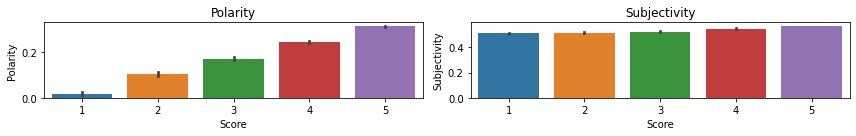

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(12, 2))
sns.barplot(data=rating_Pattern, x='Score', y='Polarity', ax=axs[0])
sns.barplot(data=rating_Pattern, x='Score', y='Subjectivity', ax=axs[1])
axs[0].set_title('Polarity')
axs[1].set_title('Subjectivity')
plt.tight_layout()
plt.show()

***Business Insights***

Here we can see that high scores are having high polarity which means  that higher scores are having postive sentiments.

All the subjectivity scores are above 0.4, a higher subjectivity score implies that we are having more personal sentences.

***Using TEXTBLOB***

In [74]:
from textblob import TextBlob

In [98]:
rating_tb = pd.DataFrame(rating_df, columns=['Score', 'Text','cleanText'])

In [99]:
def sentiment_analysis(rating_tb):
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 rating_tb['TextBlob_Subjectivity'] = rating_tb['cleanText'].apply(getSubjectivity)
 rating_tb['TextBlob_Polarity'] = rating_tb['cleanText'].apply(getPolarity)
 def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
 rating_tb['TextBlob_Analysis'] = rating_tb['TextBlob_Polarity'].apply(getAnalysis)
 return rating_tb

In [100]:
sentiment_analysis(rating_tb)

,Score,Text,cleanText,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
124918,1,"I purchased this thinking ""what a great deal!""...",purchased thinking great deal know really bad ...,0.422619,0.010714,Positive
147399,4,"These thinkThin ""100 Chocolate Toffee Nut Bite...",thinkthin chocolate toffee nut bite good tasti...,0.425000,0.362500,Positive
5435,5,I purchased some of this special habanero sauc...,purchased special habanero sauce past year sup...,0.546958,0.336640,Positive
497248,3,My daughter loves this stuff. I thought it ta...,daughter love stuff thought tasted pretty good...,0.643750,0.164062,Positive
219223,4,I have tried virtually every variety of the Bo...,tried virtually every variety body armor brand...,0.617949,0.234615,Positive
...,...,...,...,...,...,...
286291,3,I am an expat living in Thailand so I know a t...,expat living thailand know thing two thai spic...,0.504889,0.134000,Positive
390514,3,This product is widely available in my area at...,product widely available area local grocery st...,0.465741,0.123611,Positive
295707,2,My main beef with this product is with the lab...,main beef product labeling box labeled decepti...,0.483333,-0.070909,Negative
465988,4,I have been drinking this tea every night just...,drinking tea every night benefit claim produce...,0.423485,-0.049242,Negative


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Positive vs Negative vs Neutral Label count')

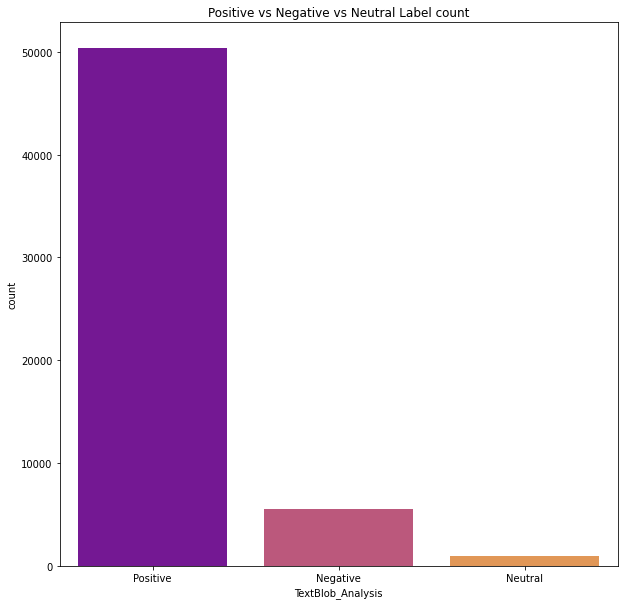

In [102]:
import seaborn as sns
sns.countplot(rating_tb['TextBlob_Analysis'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Positive vs Negative vs Neutral Label count')

***Business Insights***

We have highest number of positive sentiments for this product/service. So, we can say that this product/service is doing ***great*** in the market.

We have observe that this product/service is having very less negative sentiments as compare to their positive ones which shows that the market is ***BOOM*** for them.